In [2]:
# For some reason tensorflow needs to be imported before other modules, otherwise the
# kernel crashes...

%matplotlib inline

import tensorflow as tf 

import pandas as pd
import random
import numpy as np

In [3]:
import data_utils as dtl

df = dtl.get_vid_2d_encod()

feat_cols = df.columns[:4096]

In [4]:
X = df[feat_cols].values
ids,text_labels = df.label.factorize()
Y = ids

In [5]:
from sklearn.model_selection import train_test_split
# test_size: what proportion of original data is used for test set
train_images, test_images, train_labels, test_labels = train_test_split(
    X, Y, test_size=1/7.0, random_state=0)

In [6]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
one_hot_train_labels = lb.fit_transform(train_labels)
one_hot_test_labels = lb.fit_transform(test_labels)


In [7]:

n_classes = len(np.unique(Y))
input_dim = X.shape[1]
n_classes,input_dim

(7, 4096)

In [8]:
def reorganizeMNIST(x, y):
    print(x.shape[0],y.shape[0])
    assert x.shape[0] == y.shape[0]
    
    dataset = {i: [] for i in range(n_classes)}
    
    for i in range(x.shape[0]):
        dataset[y[i]].append(x[i])
        
    return dataset

def get_batch(dataset, k):
    # Sample BATCH_K random images from each category of the MNIST dataset,
    # returning the data along with its labels
    batch = []
    labels = []
    
    for l in range(n_classes):
        indices = random.sample(range(len(dataset[l])), k)
        indices = np.array(indices)

        batch.append([dataset[l][i] for i in indices])
        labels += [l] * k

    batch = np.array(batch).reshape(n_classes * k, 64, 64, 1)
    labels = np.array(labels)
    
    # Shuffling labels and batch the same way
    s = np.arange(batch.shape[0])
    
#     np.random.shuffle(s)
    
    batch = batch[s]
    labels = labels[s]
    
    return batch, labels

In [9]:
train_set = reorganizeMNIST(train_images, train_labels.reshape(-1))
valid_set = reorganizeMNIST(test_images, test_labels.reshape(-1))

16555 16555
2760 2760


In [10]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context('notebook', font_scale=1.5,
                rc={"lines.linewidth": 2.5})

from sklearn.manifold import TSNE

def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", n_classes))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(n_classes):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, text_labels[i], fontsize=14)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.show()

In [11]:
# Getting a batch from training and validation data for visualization
x_train, y_train = get_batch(train_set, 128)
x_val, y_val = get_batch(valid_set, 128)

x_train = x_train.reshape(-1, 4096)
x_val = x_val.reshape(-1, 4096)

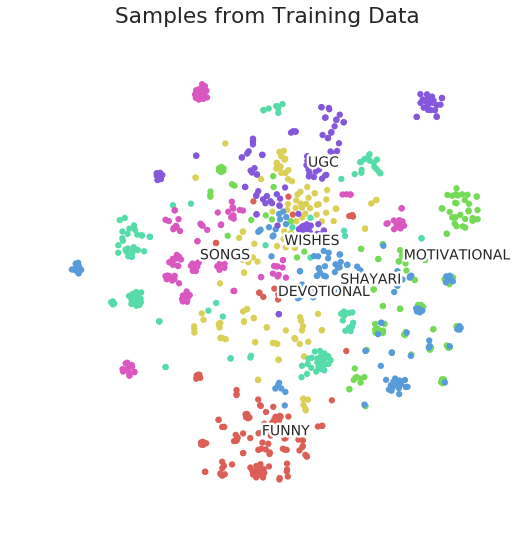

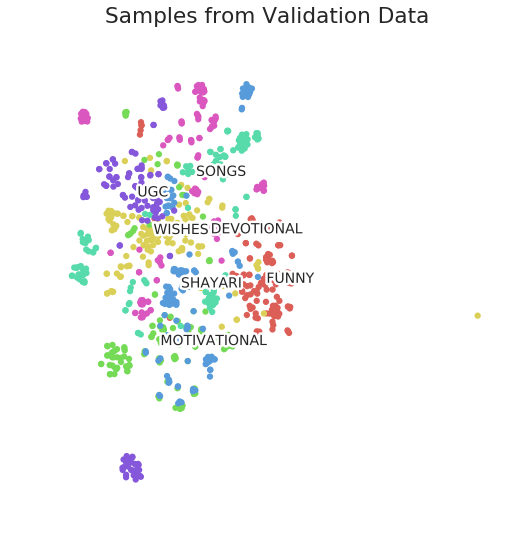

In [12]:
    
# Generating and visualizing t-SNE embeddings of the raw data
# of the first 512 samples.
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(x_train)
scatter(train_tsne_embeds, y_train, "Samples from Training Data")

eval_tsne_embeds = tsne.fit_transform(x_val)
scatter(eval_tsne_embeds, y_val, "Samples from Validation Data")

In [13]:
#import tensorflow as tf

def all_diffs(a, b):
    # Returns a tensor of all combinations of a - b
    return tf.expand_dims(a, axis=1) - tf.expand_dims(b, axis=0)

def euclidean_dist(embed1, embed2):
    # Measures the euclidean dist between all samples in embed1 and embed2
    
    diffs = all_diffs(embed1, embed2) # get a square matrix of all diffs
    return tf.sqrt(tf.reduce_sum(tf.square(diffs), axis=-1) + 1e-12)


TL_MARGIN = 0.2 # The minimum distance margin
def bh_triplet_loss(dists, labels):
    # Defines the "batch hard" triplet loss function.
    
    same_identity_mask = tf.equal(tf.expand_dims(labels, axis=1),
                                  tf.expand_dims(labels, axis=0))
    negative_mask = tf.logical_not(same_identity_mask)
    positive_mask = tf.logical_xor(same_identity_mask,
                                   tf.eye(tf.shape(labels)[0], dtype=tf.bool))

    furthest_positive = tf.reduce_max(dists*tf.cast(positive_mask, tf.float32), axis=1)
    closest_negative = tf.map_fn(lambda x: tf.reduce_min(tf.boolean_mask(x[0], x[1])),
                                (dists, negative_mask), tf.float32)
    
    diff = furthest_positive - closest_negative
    
    return tf.maximum(diff + TL_MARGIN, 0.0)

EMBEDDING_DIM = 4 # Size of the embedding dimension (units in the last layer)
def embedImages(Images):
    conv1 = tf.layers.conv2d(Images,
                             filters=128, kernel_size=(7, 7),
                             padding='same',
                             activation=tf.nn.relu,
                             kernel_initializer=tf.truncated_normal_initializer,
                             name='conv1')
    
    pool1 = tf.layers.max_pooling2d(conv1,
                                    pool_size=(2, 2), strides=(2, 2),
                                    padding='same',
                                    name='pool1')
    
    conv2 = tf.layers.conv2d(pool1,
                             filters=256, kernel_size=(5, 5),
                             padding='same',
                             activation=tf.nn.relu,
                             kernel_initializer=tf.truncated_normal_initializer,
                             name='conv2')
    
    pool2 = tf.layers.max_pooling2d(conv2,
                                    pool_size=(2, 2), strides=(2, 2),
                                    padding='same',
                                    name='pool2')
    
    flat = tf.layers.flatten(pool2, name='flatten')
    
    # Linear activated embeddings
    embeddings = tf.layers.dense(flat,
                                 activation=None,
                                 kernel_initializer=tf.truncated_normal_initializer,
                                 units=EMBEDDING_DIM,
                                 name='embeddings')
    
#     embeddings = tf.nn.softmax(embeddings,name='softmax_logit')
    
    return embeddings

In [14]:
# Placeholders for inserting data
Images = tf.placeholder(tf.float32, [None, 64, 64, 1], name='images_ph')
Labels = tf.placeholder(tf.int32, [None], name='labels_ph')

# Embeds images using the defined model
embedded_images = embedImages(Images)

# Measure distance between al embeddings
dists = euclidean_dist(embedded_images, embedded_images)

# Calculate triplet loss for the give dists
loss = tf.reduce_mean(bh_triplet_loss(dists, Labels))

global_step = tf.Variable(0, trainable=False, name='global_step')
learning_rate = tf.train.exponential_decay(0.001, global_step, 5000, 0.96, staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(loss=loss, global_step=global_step)

/home/deep-vision/.virtualenvs/video-works/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [15]:
from tqdm import tqdm

In [16]:
config = tf.ConfigProto(
        device_count = {'GPU': 1}
    )
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    tf.global_variables_initializer().run()
    
    loss_hist = []
    lr_hist = []
    # Train for 5000 epochs
    for i in tqdm(range(5000)):
        data, labels = get_batch(train_set, 64)
        
        feed_dict = {Images: data, Labels: labels}
        
        _, lr, raw_loss, embeddings = sess.run([train_step,
            optimizer._lr, loss, embedded_images], feed_dict)
        
    
        
        lr_hist.append(lr)
        loss_hist.append(raw_loss)
    
    print("[INFO] loss after {} epochs = {}, lr = {}".format(i,round(raw_loss,2),round(lr,8)))    
    # Training is finished, get a batch from training and validation
    # data to visualize the results
    x_train, y_train = get_batch(train_set, 128)
    x_val, y_val = get_batch(valid_set, 128)
    
    # Embed the images using the network
    train_embeds = sess.run(embedded_images, 
                            feed_dict={Images: x_train, Labels:y_train})
    val_embeds = sess.run(embedded_images,
                          feed_dict={Images: x_val, Labels: y_val})
    

100%|██████████| 5000/5000 [37:52<00:00,  2.20it/s]


[INFO] loss after 4999 epochs = 2177.699951171875, lr = 0.0010000000474974513


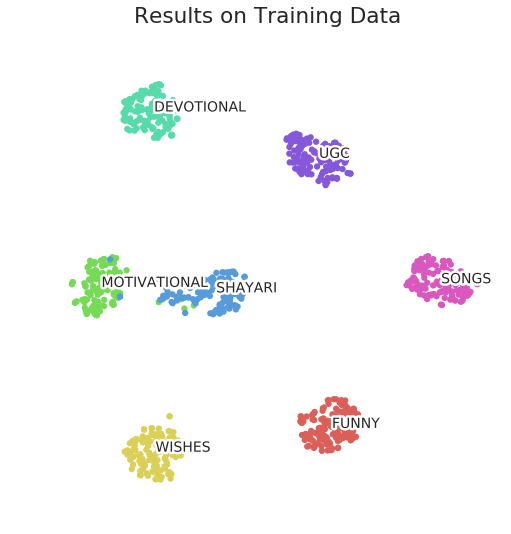

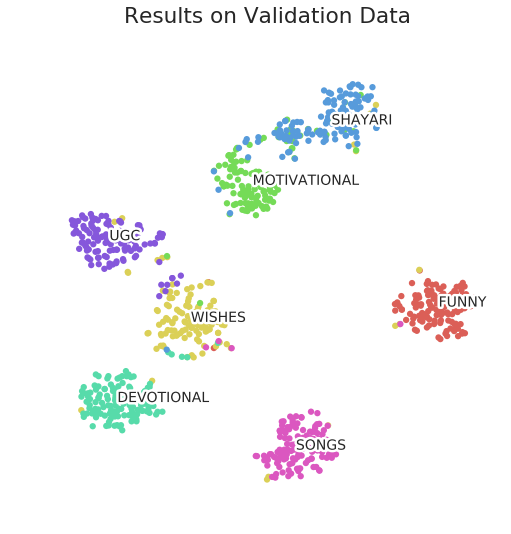

In [21]:
tsne_train = tsne.fit_transform(train_embeds)
tsne_val = tsne.fit_transform(val_embeds)

scatter(tsne_train, y_train, "Results on Training Data")
scatter(tsne_val, y_val, "Results on Validation Data")

In [ ]:
plt.plot(loss_hist)
plt.ylabel('loss')
plt.ylabel('# epochs')
plt.show()

In [ ]:
plt.plot(lr_hist)
plt.ylabel('learning rate')
plt.show()

In [20]:
import all_classifiers as cls
cls.train_and_report(train_embeds, y_train,val_embeds,y_val,algo_name='mlp',epochs=50,batch_size=128)

Epoch 1/50
896/896 [==============================] - 0s 360us/step - loss: 1.5381 - acc: 0.4676
Epoch 2/50
896/896 [==============================] - 0s 48us/step - loss: 0.7585 - acc: 0.7511
Epoch 3/50
896/896 [==============================] - 0s 49us/step - loss: 0.5726 - acc: 0.8393
Epoch 4/50
896/896 [==============================] - 0s 48us/step - loss: 0.4846 - acc: 0.8850
Epoch 5/50
896/896 [==============================] - 0s 54us/step - loss: 0.4199 - acc: 0.8940
Epoch 6/50
896/896 [==============================] - 0s 53us/step - loss: 0.3641 - acc: 0.9051
Epoch 7/50
896/896 [==============================] - 0s 54us/step - loss: 0.3438 - acc: 0.9051
Epoch 8/50
896/896 [==============================] - 0s 55us/step - loss: 0.3090 - acc: 0.9397
Epoch 9/50
896/896 [==============================] - 0s 54us/step - loss: 0.2953 - acc: 0.9219
Epoch 10/50
896/896 [==============================] - 0s 55us/step - loss: 0.2771 - acc: 0.9319
Epoch 11/50
896/896 [=================